# Spam Classification with TensorFlow

The below code uses the template from the [Intro to TensorFlow for Deep Learning](https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187) tutorial, of which the original authors **(Copyright 2020 The TensorFlow Authors)** have made available under the Apache 2.0 license.

The original source code can be found [here](https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l09c04_nlp_embeddings_and_sentiment.ipynb).

Modifications have been made to the below code for the purpose of generating appropriate analyses on the Spam Text Message Classification dataset from [Kaggle](https://www.kaggle.com/team-ai/spam-text-message-classification).

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Word Embeddings

## Import TensorFlow and Dataset

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# get data files
#wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



In [4]:
dataset = pd.read_csv('train-data.tsv',sep='\t',names=['Category','Message'])
dataset['Category'] = dataset['Category'].map({'ham':0,'spam':1})
dataset

,Category,Message
0,0,ahhhh...just woken up!had a bad dream about u ...
1,0,you can never do nothing
2,0,"now u sound like manky scouse boy steve,like! ..."
3,0,mum say we wan to go then go... then she can s...
4,0,never y lei... i v lazy... got wat? dat day ü ...
...,...,...
4174,0,just woke up. yeesh its late. but i didn't fal...
4175,0,what do u reckon as need 2 arrange transport i...
4176,1,free entry into our £250 weekly competition ju...
4177,1,-pls stop bootydelious (32/f) is inviting you ...


- Normalize Text
- Remove Unicode Characters
- Remove Stopwords
- Perform Stemming and Lemmatization

In [21]:
pip install ntlk

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement ntlk (from versions: none)
ERROR: No matching distribution found for ntlk


In [19]:
import re 
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords


def clean_txt(text):
    text = text.lower()
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    text = " ".join([word for word in text.split() if word not in (stop)])
    
    return text 
    

ModuleNotFoundError: No module named 'nltk'

In [17]:
text = "hey amazon - my package never arrived https://www.amazon.com/gp/css/order-history?ref_=nav_orders_first please fix asap! @amazonhelp"
clean_txt(text)

'hey amazon  my package never arrived  please fix asap amazonhelp'

In [5]:
# ham = 0, spam = 1

sentences = dataset['Message'].tolist()
labels = dataset['Category'].tolist()

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

## Tokenize the dataset

Tokenize the dataset, including padding and OOV

In [6]:
vocab_size = 600
embedding_dim = 16
max_length = 60
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

## Review a Sequence

Let's quickly take a look at one of the padded sequences to ensure everything above worked appropriately.

In [7]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

you can never do nothing ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
you can never do nothing


## Train a Text Classification Model with Embeddings

In [8]:
# Note the embedding layer is first, 
# and the output is only 1 node as it is either 0 or 1 (negative or positive)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 16)            9600      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 9,709
Trainable params: 9,709
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
105/105 [==============================] - 4s 10ms/step - loss: 0.5446 - accuracy: 0.8672 - val_loss: 0.4131 - val_accuracy: 0.8612
Epoch 2/30
105/105 [==============================] - 1s 7ms/step - loss: 0.3509 - accuracy: 0.8672 - val_loss: 0.3275 - val_accuracy: 0.8612
Epoch 3/30
105/105 [==============================] - 1s 7ms/step - loss: 0.2978 - accuracy: 0.8672 - val_loss: 0.2812 - val_accuracy: 0.8612
Epoch 4/30
105/105 [==============================] - 1s 7ms/step - loss: 0.2509 - accuracy: 0.8672 - val_loss: 0.2284 - val_accuracy: 0.8612
Epoch 5/30
105/105 [==============================] - 1s 7ms/step - loss: 0.2042 - accuracy: 0.8953 - val_loss: 0.1842 - val_accuracy: 0.9366
Epoch 6/30
105/105 [==============================] - 1s 8ms/step - loss: 0.1661 - accuracy: 0.9408 - val_loss: 0.1513 - val_accuracy: 0.9533
Epoch 7/30
105/105 [==============================] - 1s 7ms/step - loss: 0.1355 - accuracy: 0.9560 - val_loss: 0.1256 - val_accuracy: 0.9677
Epoch

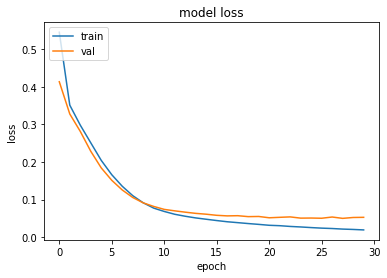

In [9]:
num_epochs = 30
history=model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [10]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(600, 16)


In [13]:
import io

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

## Detecting Spam Across New Messages

In [11]:
# Use the model to predict whether a message is spam
text_messages = ['Greg, can you call me back once you get this?',
                'Congrats on your new iPhone! Click here to claim your prize...', 
                'Really like that new photo of you',
                'Did you hear the news today? Terrible what has happened...',
                'Attend this free COVID webinar today: Book your session now...',
                'Are you coming to the party tonight?',
                'Your parcel has gone missing',
                'Do not forget to bring friends!',
                'You have won a million dollars! Fill out your bank details here...',
                'Looking forward to seeing you again']

print(text_messages) 

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(text_messages)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)           

classes = model.predict(fakes_padded)

# The closer the class is to 1, the more likely that the message is spam
for x in range(len(text_messages)):
  print(text_messages[x])
  print(classes[x])
  print('\n')

['Greg, can you call me back once you get this?', 'Congrats on your new iPhone! Click here to claim your prize...', 'Really like that new photo of you', 'Did you hear the news today? Terrible what has happened...', 'Attend this free COVID webinar today: Book your session now...', 'Are you coming to the party tonight?', 'Your parcel has gone missing', 'Do not forget to bring friends!', 'You have won a million dollars! Fill out your bank details here...', 'Looking forward to seeing you again']
Greg, can you call me back once you get this?
[0.03547022]


Congrats on your new iPhone! Click here to claim your prize...
[0.7169639]


Really like that new photo of you
[0.00388939]


Did you hear the news today? Terrible what has happened...
[0.00114235]


Attend this free COVID webinar today: Book your session now...
[0.5938423]


Are you coming to the party tonight?
[0.00082015]


Your parcel has gone missing
[0.00989601]


Do not forget to bring friends!
[0.00142587]


You have won a million

In [13]:
test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(test_messages)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)           

classes = model.predict(fakes_padded)


# The closer the class is to 1, the more likely that the message is spam
for x in range(len(test_messages)):
  print(test_messages[x])
  print(classes[x])
  print('\n')


how are you doing today
[0.00146956]


sale today! to stop texts call 98912460324
[0.38843557]


i dont want to go. can we try it a different day? available sat
[0.00012865]


our new mobile video service is live. just install on your phone to start watching.
[0.94648993]


you have won £1000 cash! call to claim your prize.
[0.9957539]


i'll bring it tomorrow. don't forget the milk.
[8.606891e-05]


wow, is your arm alright. that happened to me one time too
[0.00237285]


